In [84]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import cmcrameri as cmcm
import juanfit

In [85]:
df = pd.read_excel("../../save/eis_line_list_final_v2.xlsx",sheet_name="resolve")
df["ion"] = df["ion"].str.strip()
df["charge_stat"] = df["charge_stat"].str.strip()
df["quality"] = df["quality"].str.strip()
df["fwhm_true_err"] = df["fwhm_fit"]/df["fwhm_true"]*df["fwhm_err"]
df

,ion,charge_stat,Z,A,temp,wvl_fit,wvl_chianti,fwhm_fit,fwhm_err,fwhm_true,fwhm_awsom_fit,fwhm_awsom_err,fwhm_awsom_true,quality,desc,fwhm_true_cross,fwhm_true_err
0,Fe,x,9,55.85000,5.9,174.521,174.531,0.07940,0.00150,0.0380,0.082,0.000030,0.0434,a,NaN,0.047998,0.003134
1,Fe,ix,8,55.85000,5.8,176.971,176.945,0.06490,0.00480,NaN,0.081,0.000800,0.0414,c,NaN,0.014541,NaN
2,Fe,x,9,55.85000,5.9,177.230,177.240,0.08078,0.00064,0.0407,0.083,0.000200,0.0440,a,NaN,0.050248,0.001270
3,Fe,xi,10,55.85000,6.0,182.163,182.167,0.07950,0.00180,0.0381,0.086,0.000100,0.0503,a,NaN,0.048163,0.003756
4,Fe,x,9,55.85000,5.9,182.304,182.307,0.08680,0.00370,0.0517,0.082,0.000500,0.0423,b,NaN,0.059445,0.006212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Mg,vii,6,24.30500,5.8,280.727,280.742,0.07790,0.00740,0.0362,0.097,0.000008,0.0676,b,NaN,0.045474,0.015924
80,Al,ix,8,26.98154,5.9,282.415,282.422,0.09300,0.01600,0.0629,0.103,0.000080,0.0755,b,NaN,0.068179,0.023657
81,Al,ix,8,26.98154,5.9,284.032,284.042,0.09120,0.00760,0.0594,0.113,0.001000,0.0882,b,NaN,0.065703,0.011669
82,Fe,xv,14,55.85000,6.2,284.161,284.163,0.05600,0.00870,NaN,0.094,0.002000,0.0623,c,sim too hot,NaN,NaN


In [86]:
for index,row in df.iterrows():
    print(row["ion"],row["charge_stat"],row["wvl_chianti"],row["fwhm_true"],"{:.4f}".format(row["fwhm_true_err"]))

Fe x 174.531 0.038 0.0031
Fe ix 176.945 nan nan
Fe x 177.24 0.0407 0.0013
Fe xi 182.167 0.0381 0.0038
Fe x 182.307 0.0517 0.0062
O vi 183.937 0.0602 0.0086
O vi 184.117 0.0421 0.0027
Fe x 184.537 0.0356 0.0011
Fe viii 185.213 0.0314 0.0011
Mn viii 185.463 0.0447 0.0072
Fe viii 186.598 0.0388 0.0015
Fe viii 187.24 0.0683 0.0073
Fe xi 188.216 0.039 0.0007
Fe xi 188.299 0.039 0.0007
Fe xi 188.997 0.0505 0.0341
Fe ix 189.572 0.0198 0.0364
Fe xi 189.711 0.0497 0.0208
Fe ix 189.935 0.0291 0.0016
Fe x 190.037 0.0389 0.0011
Fe xi 190.382 0.0546 0.0148
Fe ix 191.206 0.0331 0.0042
Mn ix 191.635 0.0569 0.0063
Fe xii 192.394 0.0419 0.0047
Fe xi 192.627 0.0427 0.0031
Fe xii 193.509 0.0404 0.0010
Fe x 193.715 0.0346 0.0027
Fe viii 193.968 nan nan
Mn x 194.299 0.0306 0.0075
Fe viii 194.661 0.0331 0.0011
Fe xii 195.119 0.0475 0.0009
Fe vii 195.484 nan nan
Fe viii 195.972 0.0496 0.0013
Fe vii 196.213 0.0388 0.0247
Fe xiii 196.525 nan nan
Fe viii 197.362 0.055 0.0026
Fe ix 197.854 0.041 0.0007
Ni xi 198

In [87]:
df_test = df.loc[(df["ion"] == "Fe") & (df["charge_stat"] == "xi") & (df["quality"] == "a")]

In [88]:
def aver_err(data,err,thresh=1.e-5,iter_max=1000):
    sigma_sq = np.var(data)
    n_data = len(data)

    if type(data) is list:
        data = np.array(data)
    if type(err) is list:
        err = np.array(err)

    err_sq_mean = np.mean(np.square(err)) 
    for ii in range(iter_max):
        weight = 1./(sigma_sq + err**2)
        weight = weight/np.sum(weight)
        aver_new = np.sum(weight*data)
        sigma_new_sq = np.max([0.,n_data/(n_data - 1.)*np.sum(weight*np.square(data-aver_new)) - \
                                err_sq_mean])
        
        #print(aver_new,sigma_new_sq)
        if ((sigma_new_sq <= sigma_sq*(1+thresh)) and (sigma_sq <= sigma_new_sq*(1+thresh))):
            break
        else:
            sigma_sq = sigma_new_sq
        
    # if sigma_new_sq == 0:
    #     print("sigma_new is 0.")

    sigma_tot = np.sqrt(1./np.sum(1./(sigma_new_sq + err**2)))
    return aver_new, sigma_tot, sigma_new_sq

# print(aver_err([10,12,7,8],[0.8,1.2,0.5,1.5]))

# aver_bootstrap = np.zeros(5000)
# for ii in range(5000):
#     data = np.random.normal(9.1673963016428,np.sqrt(3.8011034789338853),4)
#     epsilon = np.random.normal(0,[0.8,1.2,0.5,1.5])
#     data_gen = data + epsilon
#     aver_bootstrap[ii], _, _ = aver_err(data_gen,[0.8,1.2,0.5,1.5]) 

# print(np.percentile(aver_bootstrap,[2.5,50,97.5]))

In [89]:
def plot_eis_awsom_width(df,ion,charge=None,quality="a",plot_awsom=True,plot_mle=False,print_df=False,
                        print_veff=False,save_fig=False,save_fname=None,bootstrap=True):
    c = const.c.cgs/1.e5

    if type(ion) is str:
        ion = [ion]
    if type(charge) is str:
        charge = [charge]
    if type(quality) is str:
        quality = [quality]
    
    if charge is None:
        df_plot = df[(df["ion"].isin(ion)) & (df["quality"].isin(quality))]
    else:
        df_plot = df[(df["ion"].isin(ion)) & (df["charge_stat"].isin(charge)) \
                    & (df["quality"].isin(quality))]

    line_name = df_plot["ion"] + r" \textsc{"+ df_plot["charge_stat"] + r"} " + \
         ((df_plot["wvl_chianti"].values).astype("int")).astype("str")

    eis_veff = df_plot["fwhm_true_cross"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    awsom_veff = df_plot["fwhm_awsom_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    eis_veff_err = df_plot["fwhm_err"]*df_plot["fwhm_fit"] \
                    /df_plot["fwhm_true_cross"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    awsom_veff_err = df_plot["fwhm_awsom_err"]*df_plot["fwhm_awsom_fit"] \
                    /df_plot["fwhm_awsom_true"]/df_plot["wvl_chianti"]*c//np.sqrt(4*np.log(2))


    n_lines = len(df_plot.index)
    plot_x = np.arange(n_lines)

    fig, ax = plt.subplots(figsize=(n_lines*1.2+2,6),constrained_layout=True)

    if plot_mle is True:
        best_est,err_tot, err_est_sq = aver_err(eis_veff,eis_veff_err)
        best_low1sig,best_up1sig = best_est - err_tot, best_est + err_tot
        best_low3sig,best_up3sig = best_est - 3*err_tot, best_est + 3*err_tot
        aver_bootstrap = np.zeros(10000)
        if bootstrap is True:
            for ii in range(10000):
                data = np.random.normal(best_est,np.sqrt(err_est_sq),len(eis_veff))
                epsilon = np.random.normal(0,eis_veff_err)
                data_gen = data + epsilon
                aver_bootstrap[ii], _, _ = aver_err(data_gen,eis_veff_err) 
            best_low3sig,best_low1sig,best_est,best_up1sig,best_up1sigbest_up3sig = \
                np.percentile(aver_bootstrap,[0.15,16,50,84,99.85])



        ax.axhspan(best_low1sig,best_up1sig,color="#FAD689",alpha=0.9)
        ax.axhspan(best_low3sig,best_up3sig,color="#FAD689",alpha=0.5)
        ax.axhline(best_est,color="#FFB11B",lw=2,ls="--",label=r"$\bar{v}_{\rm eff}$")
    
    if plot_awsom:
        ax.errorbar(plot_x,awsom_veff,awsom_veff_err,color="#0089A7",ls="none",marker="d",
                    markersize=6,capsize=5,lw=2,label="AWSoM",zorder=15)
    ax.errorbar(plot_x,eis_veff,eis_veff_err,color="#CC543A",ls="none",marker="o",
                markersize=6,capsize=5,lw=2,label="EIS",zorder=15)


    # ax.scatter(plot_x,awsom_veff,color="#0089A7",marker="o",
    #             lw=3,label="AWSoM",zorder=14)


    ax.set_xlim(left=-1,right=len(line_name))
    ax.set_xticks(plot_x)
    ax.set_xticklabels(line_name)
    ax.tick_params(labelsize=16)
    ax.set_xlabel("Line",fontsize=16)
    ax.set_ylabel(r"Effective Velocity $v_{\rm eff}\ \left[\mathrm{km \cdot s^{-1}} \right]$",
                    fontsize=16)

    if charge is not None:
        title = r"\textbf{" + ion[0] + ' '.join([r" \textsc{" + charge_ +r"} " for charge_ in charge]) + \
                r"}"
    else:
        title = r"\textbf{" + ion[0] + r"}"

    if (plot_mle is True) and (bootstrap is False):
        title = title + r" $\bar{{v}}_{{\rm eff}} = {{{:.1f}}}\pm{{{:.1f}}}\ \left[\mathrm{{km \cdot s^{{-1}}}}\right]$".format(best_est,err_tot)
    elif (plot_mle is True) and (bootstrap is True):
        title = title + \
        r" $\bar{{v}}_{{\rm eff}} = {{{:.1f}}}_{{-{:.1f}}}^{{+{:.1f}}}\ \left[\mathrm{{km \cdot s^{{-1}}}}\right]$". \
            format(best_est,best_est-best_low1sig,best_up1sig-best_est)
    ax.set_title(title,fontsize=18,pad=10)
    ax.tick_params(which="major",width=1.2,length=8,direction="in")
    ax.tick_params(which="minor",width=1.2,length=4,direction="in")
    ax.grid("on")
    ax.legend(loc = 'lower left',fontsize = 18,frameon=False,handlelength=1)

    if print_df:
        print(df_plot)

    if print_veff:
        print(eis_veff)
        print(eis_veff_err)

    if save_fig:
        plt.savefig(fname=save_fname,format=save_fname[-3:])

32    44.947436
dtype: float64
32    17.983189
dtype: float64


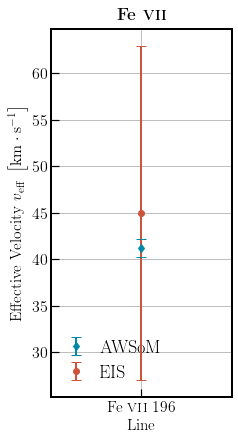

In [90]:
plot_eis_awsom_width(df,"Fe","vii",quality=["a","b"],print_veff=True)

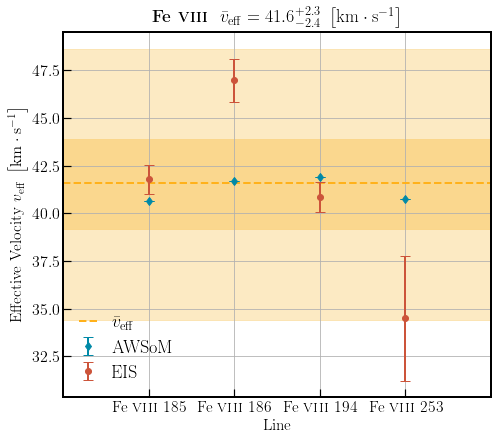

In [91]:
plot_eis_awsom_width(df,"Fe","viii",quality=["a"],plot_mle=True)

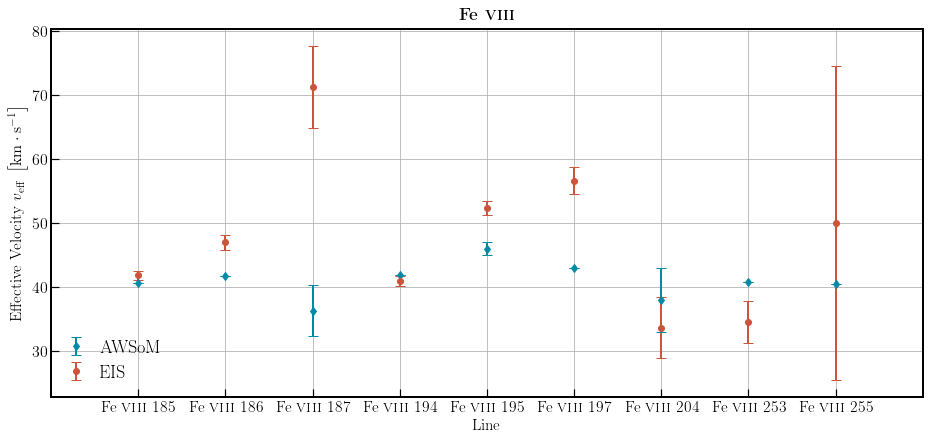

In [92]:
plot_eis_awsom_width(df,"Fe","viii",quality=["a","b"])

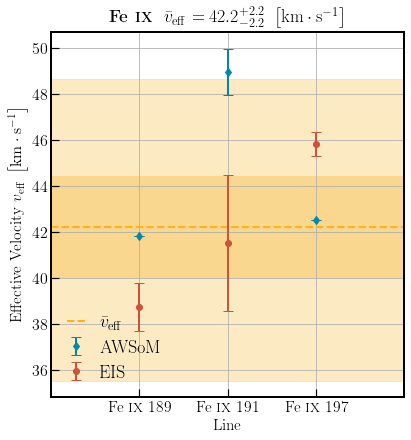

In [93]:
plot_eis_awsom_width(df,"Fe","ix",quality=["a"],plot_mle=True)

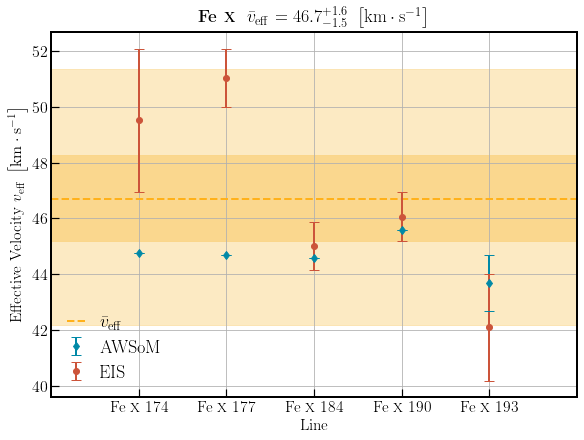

In [94]:
plot_eis_awsom_width(df,"Fe","x",quality=["a"],plot_mle=True)

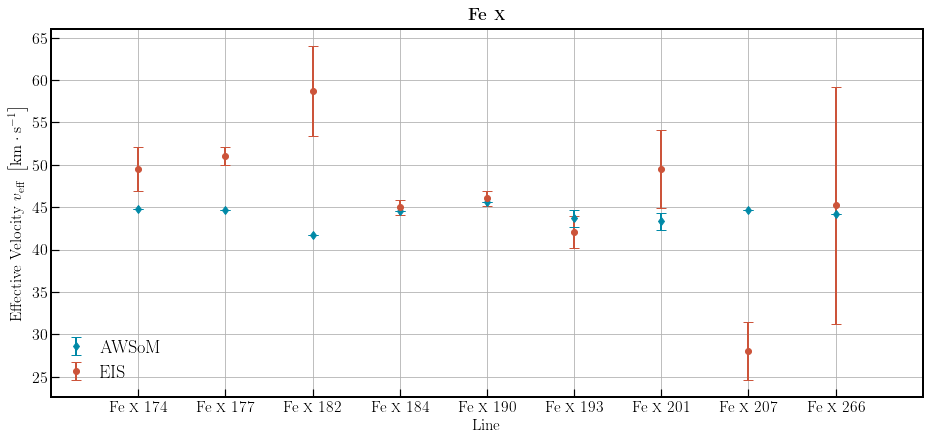

In [95]:
plot_eis_awsom_width(df,"Fe","x",quality=["a","b"],plot_mle=False)

3     47.601760
12    47.386493
13    47.365605
23    48.335711
41    52.612361
dtype: float64
3     2.936521
12    0.527472
13    0.527239
23    2.362629
41    3.906459
dtype: float64


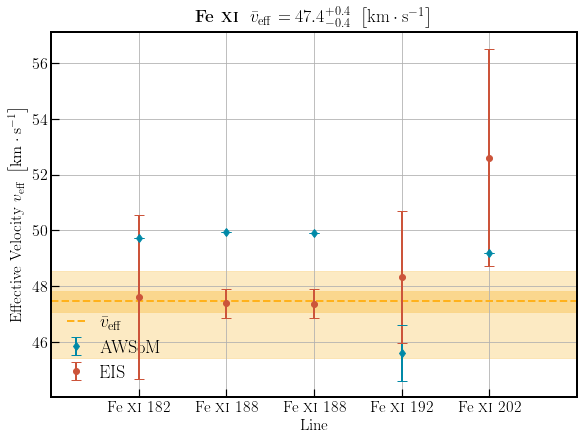

In [96]:
plot_eis_awsom_width(df,"Fe","xi",quality=["a"],plot_mle=True,print_veff=True)

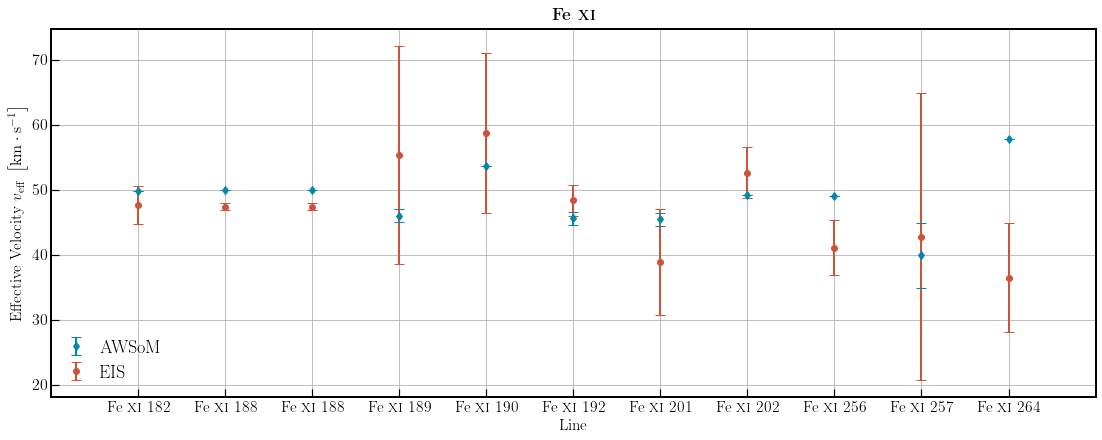

In [97]:
plot_eis_awsom_width(df,"Fe","xi",quality=["a","b"],plot_mle=False)

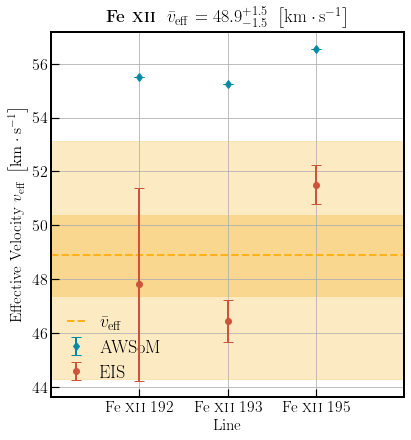

In [98]:
plot_eis_awsom_width(df,"Fe","xii",quality=["a"],plot_mle=True,save_fig=True,
save_fname="../../figs/ms/FeXII_summary_agu.pdf")

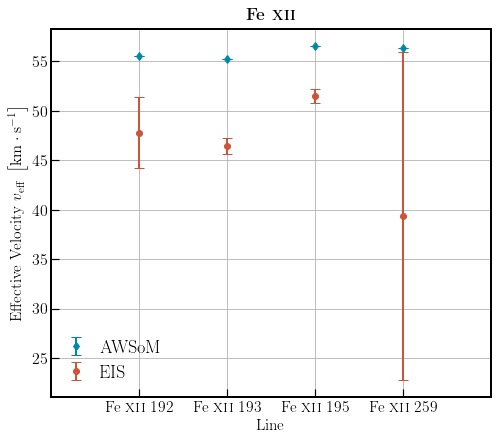

In [99]:
plot_eis_awsom_width(df,"Fe","xii",quality=["a","b"])

40    46.643939
dtype: float64
40    1.817002
dtype: float64


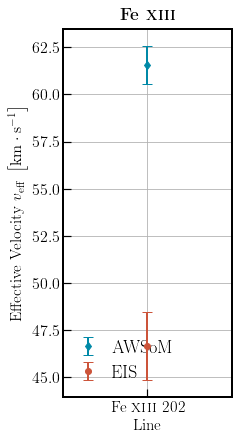

In [100]:
plot_eis_awsom_width(df,"Fe",["xiii"],quality=["a"],print_veff=True)

6    50.105064
dtype: float64
6    2.174898
dtype: float64


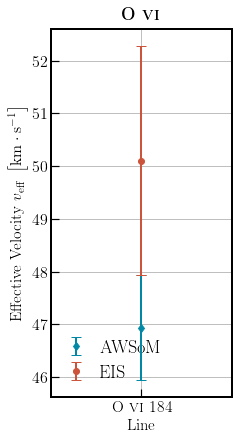

In [101]:
plot_eis_awsom_width(df,"O",["vi"],quality=["a"],print_veff=True)

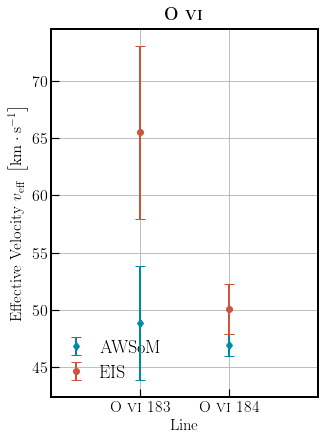

In [102]:
plot_eis_awsom_width(df,"O",["vi"],quality=["a","b"])

74    42.564347
dtype: float64
74    2.995609
dtype: float64


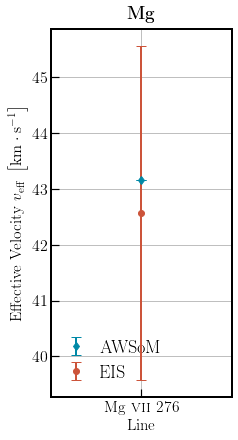

In [103]:
plot_eis_awsom_width(df,"Mg",quality=["a"],print_veff=True)

68    40.952038
74    42.564347
79    29.162842
dtype: float64
68    11.552310
74     2.995609
79     8.129812
dtype: float64


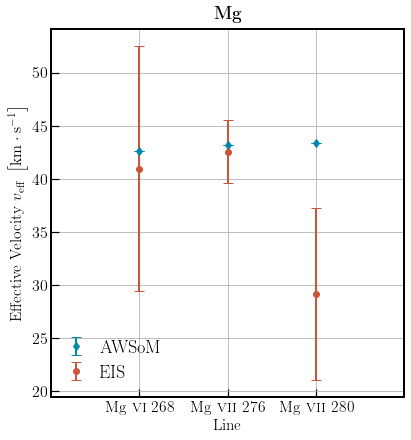

In [104]:
plot_eis_awsom_width(df,"Mg",quality=["a","b"],print_veff=True)

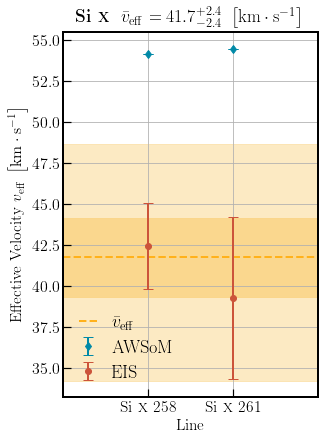

In [105]:
plot_eis_awsom_width(df,"Si","x",quality=["a"],plot_mle=True)

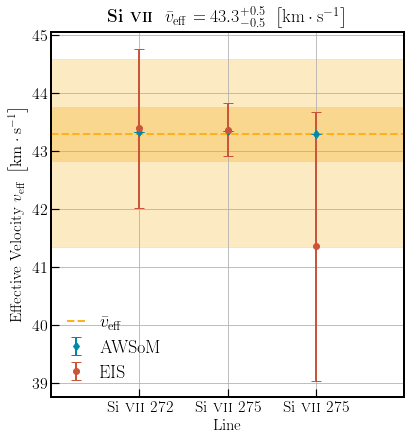

In [106]:
plot_eis_awsom_width(df,"Si","vii",quality=["a"],plot_mle=True)

59    40.651025
dtype: float64
59    18.533042
dtype: float64


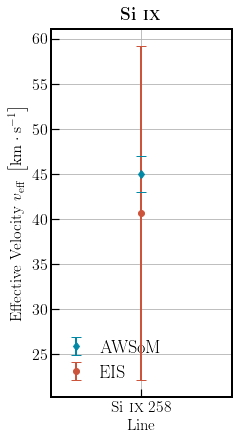

In [107]:
plot_eis_awsom_width(df,"Si","ix",quality=["a","b"],print_veff=True)

61    46.353447
64    40.305811
dtype: float64
61    9.554334
64    5.885643
dtype: float64


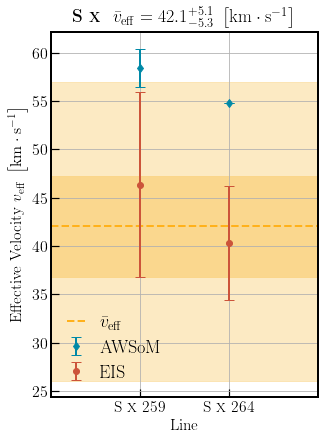

In [108]:
plot_eis_awsom_width(df,"S","x",quality=["a"],plot_mle=True,print_veff=True)

9     51.873417
21    60.154107
27    39.377810
37    32.377027
dtype: float64
9      5.866668
21     5.282549
27     4.984705
37    14.657177
dtype: float64


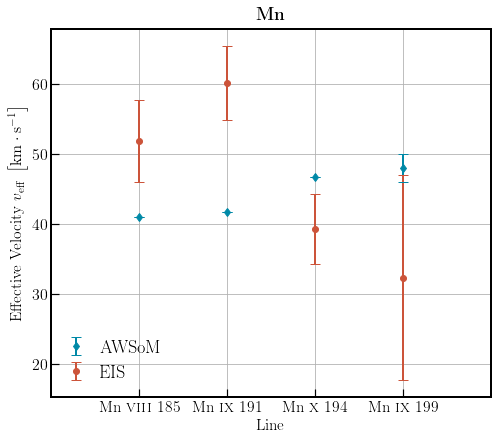

In [109]:
plot_eis_awsom_width(df,"Mn",quality=["a","b"],print_veff=True)

43    56.335159
46    40.235932
dtype: float64
43    7.895543
46    3.443267
dtype: float64


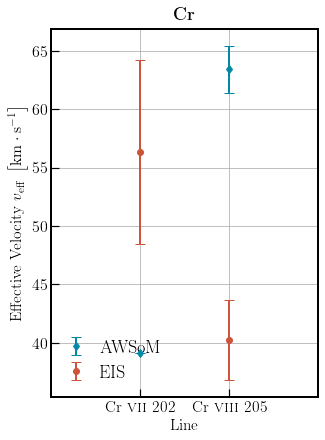

In [110]:
plot_eis_awsom_width(df,"Cr",quality=["a","b"],print_veff=True)

36    66.610053
dtype: float64
36    9.821219
dtype: float64


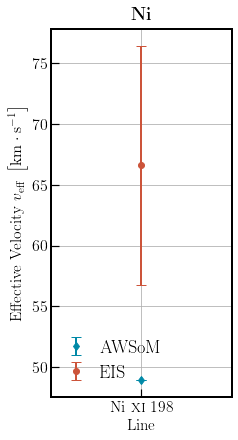

In [111]:
plot_eis_awsom_width(df,"Ni",quality=["a","b"],print_veff=True)